# Greenhouse Model

## Import dependencies and data

In [1]:
# import dependencies
import os
import pickle
import json
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy.stats import wilcoxon


from IPython.display import clear_output

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\kfold_results\\models\\'
results_path = home_path + '\\model\\kfold_results\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

## MISC

In [4]:
def abs_humid(temp, rel_humid):
    abs_humidity =  6.112 * np.exp(17.67 * temp / (temp + 243.5)) * rel_humid * 2.1674 / (273.15 + temp)
    return abs_humidity

def rel_humid(temp, abs_humid):
    rel_humidity = abs_humid * (273.15 + temp) / (6.112 * np.exp(17.67 * temp / (temp + 243.5)) * 2.1674)
    return rel_humidity

In [5]:
ta01_min = 35
ta01_max = 75

ta02_min = 0
ta02_max = 85

## Define funcs for data engi.

In [6]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
def data_reduce(data, m):
    idxObj = zip(
        data.index.get_level_values(0),
        data.index.get_level_values(1),
        data.index.get_level_values(2),
        data.index.get_level_values(3) // m
    )

    index = pd.MultiIndex.from_tuples(
        tuples=idxObj,
        names=['month', 'day', 'hour', 'minute']
    )

    data.index = index
    dates = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).last()[('time', 'date')]
    data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
    return data, dates

In [7]:
def date_flagger(data, n_steps):
    # create flag for erroneous sequences
    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [8]:
def seq_maker(data, targets, temps, dates, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask].values
    
    temps_t = temps[n_steps-t_steps:-t_steps][mask].values
    temps = temps[:-n_steps][mask].values # TEMPORARY
    
    dates = dates[:-n_steps][mask].values
    
    return sequences, targets, temps, temps_t, dates

In [9]:
def data_norm(data_train, data_test):
    col_params = {}
    for col in data_train.columns:

        min_val = data_train[col].min()
        max_val = data_train[col].max()

        # normalize
        mean = data_train[col].mean()
        std = data_train[col].std()

        data_train[col] = (data_train[col] - mean) / std
        data_test[col] = (data_test[col] - mean) / std

        col_params[col] = {
            'mean':mean,
            'std':std,
            'max':max_val,
            'min':min_val
            }
    
    return data_train, data_test, col_params

## Create func for K-fold split

In [10]:
def k_fold_data(data, k_idx, k_frac, m, cols, t_steps, n_steps, shuffle):
    
    # get days
    days = data.groupby(['month', 'day'], sort=False).count().index.values
    
    # get days for K:th fold
    train_n = int(len(days)) * (1 - k_frac)
    test_n = len(days) - train_n
    
    # split days by test and train
    days_test = days[int(k_idx*test_n):int((k_idx+1)*test_n)].tolist()
    mask_test = np.array([day in days_test for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
    data_train = data.loc[~mask_test].copy()
    data_test = data.loc[mask_test].copy()
    
    # reduce to m-min observations
    data_train, dates_train = data_reduce(data_train, m)
    data_test, dates_test = data_reduce(data_test, m)
    
#     # get dates
#     dates_train = data_train.time.date.values
#     dates_test = data_test.time.date.values
    
#     # remove setpoint
#     data_train[('temperatures', 'TA01_GT10X_GM10X')] -= data_train.setpoints.TA01_GT10X_GM10X + 20
#     data_test[('temperatures', 'TA01_GT10X_GM10X')] -= data_test.setpoints.TA01_GT10X_GM10X + 20
    
    # filter data
    data_train = data_train[cols].copy()
    data_test = data_test[cols].copy()
    
    # normalize
    data_train, data_test, col_params = data_norm(data_train, data_test)
    
    # get targets
    targets_train = data_train.pop(('temperatures', 'TA01_GT10X_GM10X'))
    targets_test = data_test.pop(('temperatures', 'TA01_GT10X_GM10X'))
    
    # get temp info
    temps_train = targets_train.copy()
    temps_test = targets_test.copy()
    
    # create sequences
    sequences_train, targets_train, temps_train, temps_t_train, dates_train = seq_maker(data_train, targets_train, temps_train, dates_train, n_steps)
    sequences_test, targets_test, temps_test, temps_t_test, dates_test = seq_maker(data_test, targets_test, temps_test, dates_test, n_steps)
    
    # create MASKED sequences
    sequences_masked = sequences_test.copy()
    for t in range(1, t_steps):
        sequences_masked[:, -t, :] = sequences_masked[:, -(t_steps), :]
    
    if shuffle:
        # shuffle training data randomly
        idxs = np.arange(len(targets_train))
        np.random.shuffle(idxs)

        sequences_train = sequences_train[idxs]
        targets_train = targets_train[idxs]
        temps_train = temps_train[idxs]
        temps_t_trian = temps_t_train[idxs]
        dates_train = dates_train[idxs]
    
    # return tups w. train and test
    train_tup = (sequences_train, targets_train, temps_train, temps_t_train, dates_train)
    test_tup = (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, dates_test)
    return train_tup, test_tup, col_params

## Create data for specific fold

In [11]:
m = 5
t_steps = 3
n_steps = 12
k_frac = 0.05

In [12]:
# Define cols to use
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
#     ('temperatures', 'TA01_GT401_GM401_scaled'),
#     ('temperatures', 'DC_GT301_damped_scaled'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('sun', 'gsi'),
    ('power', 'phase'),
    ('time', 'minofday'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output')
]

## Def model funcs

In [13]:
def model_builder(model_name, lr, dropout, stddev):
    
    tf.keras.backend.clear_session()
    inputs = layers.Input(shape=(sequences_train.shape[1], sequences_train.shape[2]))
    inputs = layers.BatchNormalization()(inputs)

    _, encoder, _ = layers.LSTM(units=128, recurrent_dropout=dropout, return_sequences=False, return_state=True)(inputs)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Dropout(dropout)(encoder)

    temp_input = layers.Input(shape=(1,))
    temp = layers.GaussianNoise(stddev=stddev)(temp_input)
    temp = layers.BatchNormalization()(temp)

    output = layers.Concatenate()([encoder, temp])
    output = layers.Dense(units=1, activation=None, use_bias=False)(output)

    model = Model([inputs, temp_input], output)
    
    lr = lr
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    
    return model

# Define training loop

In [14]:
for k_idx in range(17, 20):
    
    # get data
    train_tup, test_tup, _ = k_fold_data(
        data=data, 
        k_idx=k_idx, 
        k_frac=k_frac, 
        m=m, 
        cols=cols, 
        t_steps=t_steps, 
        n_steps=n_steps,
        shuffle=False
    )
    
    (sequences_train, targets_train, temps_train, temps_t_train, _) = train_tup
    (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, _) = test_tup
    
    ### TRAIN RNN
    clear_output()
    print('TRAINING LSTM, k_idx: {}'.format(k_idx))
    
    lstm_name = 'temp_lstm_w128_k{}_v4'.format(k_idx)
    lstm_model = model_builder(model_name=lstm_name, lr=0.001, dropout=0.0, stddev=1.0)
    trainHist = lstm_model.fit(
        [sequences_train, temps_train],
        targets_train,
        epochs=30,
        batch_size=32,
        validation_split=0.0
    )

    # save results f. retrained LSTM
    with open(results_path + '{}.pickle'.format(lstm_name), 'wb') as fo:
        pickle.dump(trainHist, fo)
    
    # save model
    lstm_model.save(save_path + lstm_name)
    
    clear_output()
    print('RETRAINING LSTM, k_idx: {}'.format(k_idx))
    
    # retrain RNN
    retrained_name = lstm_name + '_X'
    lstm_retrained = model_builder(model_name=retrained_name, lr=0.0001, dropout=0.2, stddev=1.0)
    
    # copy weigths from pre-trained
    for idx, layer in enumerate(lstm_retrained.layers):
        layer.set_weights(lstm_model.layers[idx].get_weights())
    
    # retrain model
    trainHist = lstm_retrained.fit(
        [sequences_train, temps_t_train],
        targets_train,
        epochs=10,
        batch_size=128,
        validation_split=0.0
    )
    
    # save results f. retrained LSTM
    with open(results_path + '{}.pickle'.format(retrained_name), 'wb') as fo:
        pickle.dump(trainHist, fo)
    
    # save model
    lstm_retrained.save(save_path + retrained_name)
    
#     ### TRAIN ARIMA
#     clear_output()
#     print('TRAINING ARIMA, k_idx: {}'.format(k_idx))
    
#     # get model name
#     arima_name = 'temp_arima_v{}'.format(k_idx)
    
#     # get endogenous and exogenous regressors
#     endog_train = temps_t_train.tolist()
# #     exog_train = [np.array(seq) for seq in sequences_train[:, -1, :].tolist()]
#     exog_train = [np.array(seq).mean(axis=0) for seq in sequences_train[:, -t_steps:, :].tolist()]

#     endog_test = temps_t_test.tolist()
#     exog_test = [np.array(seq) for seq in sequences_masked[:, -1, :].tolist()]
# #     exog_test = [np.array(seq).mean(axis=0) for seq in sequences_test[:, -t_steps:, :].tolist()]
    
#     # estimate model
#     arima_temp = ARIMA(endog=endog_train, exog=exog_train, order=(9, 1, 0)).fit()
    
#     # get predictions (t steps)
#     print('PREDICTING w. ARIMA, k_idx: {}'.format(k_idx))
#     arima_preds = []
#     for exog in exog_test:
#         pred = arima_temp.forecast(steps=t_steps, exog=[exog] * t_steps)
#         arima_preds.append(pred[-1])

#     arima_temp.save(save_path + arima_name)
#     with open(results_path + '{}_v2.pickle'.format(arima_name), 'wb') as fo:
#         pickle.dump(arima_preds, fo)
        
        
#     ### TRAIN GBDT
#     clear_output()
#     print('TRAINING GBDT, k_idx: {}'.format(k_idx))
    
#     # get model name
#     gbdt_name = 'temp_gbdt_v{}'.format(k_idx)
#     gbdt = GradientBoostingRegressor(
#         loss='squared_error',
#         learning_rate=0.05,
#         n_estimators=6000,
#         max_depth=40,
#         max_leaf_nodes=None,
#         #subsample=0.7,
#         verbose=1,
# #         n_iter_no_change=10,
# #         tol=1e-4,
# #         validation_fraction=0.1
#     )
    
#     # train GBDT
#     X_train = np.hstack((np.stack(exog_train), temps_t_train[:, np.newaxis]))
#     Y_train = targets_train[:, np.newaxis]
#     gbdt.fit(X_train, Y_train.flatten())
    
# #     # get GBDT preds
# #     X_test = np.hstack((np.stack(exog_test), temps_t_test[:, np.newaxis]))
# #     gbdt_preds = gbdt.predict(X_test)
    
#     # save GBDT preds
#     with open(save_path + '{}_v2.pickle'.format(gbdt_name), 'wb') as fo:
#         pickle.dump(gbdt, fo)

RETRAINING LSTM, k_idx: 19
Epoch 1/10
245/245 [==============================] - 9s 31ms/step - loss: 0.2001
Epoch 2/10
245/245 [==============================] - 9s 35ms/step - loss: 0.1626
Epoch 3/10
245/245 [==============================] - 9s 38ms/step - loss: 0.1422
Epoch 4/10
245/245 [==============================] - 9s 38ms/step - loss: 0.1303
Epoch 5/10
245/245 [==============================] - 8s 34ms/step - loss: 0.1239
Epoch 6/10
245/245 [==============================] - 8s 35ms/step - loss: 0.1180
Epoch 7/10
245/245 [==============================] - 8s 32ms/step - loss: 0.1124
Epoch 8/10
245/245 [==============================] - 8s 31ms/step - loss: 0.1095
Epoch 9/10
245/245 [==============================] - 7s 30ms/step - loss: 0.1046
Epoch 10/10
245/245 [==============================] - 8s 33ms/step - loss: 0.1024
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
.

INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\kfold_results\models\temp_lstm_w128_k19_v4_X\assets


INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\kfold_results\models\temp_lstm_w128_k19_v4_X\assets


### 

### Compare LSTM and ARIMA

In [13]:
# def date_resample(targets, sequences, dates):
    
#     sequences = [np.array(seq) for seq in sequences[:, -1, :].tolist()].copy()    
#     data = pd.DataFrame(index=pd.to_datetime(dates), data={'targets':targets, 'sequences':sequences})
#     data = data.resample(rule='5min', axis='index', origin=data.index[0]).asfreq()
    
#     targets = data.targets.to_list()
#     dates = data.index.to_list()
    
#     seqs = data.sequences.values
#     seq_mask = [type(seq) != np.ndarray for seq in seqs]
#     for idx, check in enumerate(seq_mask):
#         if check:
#             seqs[idx] = np.zeros(len(seqs[0]))# * np.nan
#             #targets[idx] = np.nan
            
#     seqs = seqs.tolist()
    
#     return targets, seqs, dates

### Get Autoregressive test preds for LSTM and GBDT

In [14]:
for k_idx in range(7, 20):
    # get data
    _, test_tup, col_params = k_fold_data(
        data=data, 
        k_idx=k_idx, 
        k_frac=k_frac, 
        m=m, 
        cols=cols, 
        t_steps=t_steps, 
        n_steps=n_steps,
        shuffle=False
    )
    
    # get test data
    (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, dates_test) = test_tup
    
    clear_output()
    print('Autoregressive LSTM, k_idx: {}'.format(k_idx))
    
    # load LSTM
    lstm_name = 'temp_lstm_w128_k{}_v4_X'.format(k_idx)
    lstm = tf.keras.models.load_model(save_path + lstm_name)
    
    # create queue for preds
    pred_queue = deque(maxlen=t_steps)
    for temp in temps_t_test[:t_steps]:
        pred_queue.append(temp)
    
    # iterate over test seqs and get preds
    lstm_preds = []
    for seq in sequences_masked:
        temp = np.array([pred_queue.popleft()])
        temp_pred = lstm.predict([seq[np.newaxis, :], temp], verbose=False)[0]
        pred_queue.append(temp_pred)
        lstm_preds.append(temp_pred)
        
    # save autoregressive predictions
    with open(results_path + '{}_autoreg.pickle'.format(lstm_name), 'wb') as fo:
        pickle.dump(lstm_preds, fo)
        
#     clear_output()
#     print('Autoregressive GBDT, k_idx: {}'.format(k_idx))
    
#     # load GBDT
#     gbdt_name = 'temp_gbdt_v{}_v2'.format(k_idx)
#     with open(save_path + '{}.pickle'.format(gbdt_name), 'rb') as fo:
#         gbdt = pickle.load(fo)

#     # create queue for preds
#     pred_queue = deque(maxlen=t_steps)
#     for temp in temps_t_test[:t_steps]:
#         pred_queue.append(temp)
    
#     # iterate over test seqs and get preds
#     gbdt_preds = []
#     X_test = [np.array(seq) for seq in sequences_masked[:, -1, :].tolist()]
#     X_test = np.hstack((np.stack(X_test), temps_t_test[:, np.newaxis]))

#     for x in X_test:
#         temp = np.array([pred_queue.popleft()])
#         x[-1] = temp
#         temp_pred = gbdt.predict(x[np.newaxis, :])
#         pred_queue.append(temp_pred)
#         gbdt_preds.append(temp_pred)
        
#     # save autoregressive predictions
#     with open(results_path + '{}_autoreg.pickle'.format(gbdt_name), 'wb') as fo:
#         pickle.dump(gbdt_preds, fo)

Autoregressive LSTM, k_idx: 19


### Compare LSTM and ARIMA across all folds

In [15]:
results_dict = {}

for k_idx in range(20): 
    # get data
    _, test_tup, col_params = k_fold_data(
        data=data, 
        k_idx=k_idx, 
        k_frac=k_frac, 
        m=m, 
        cols=cols, 
        t_steps=t_steps, 
        n_steps=n_steps,
        shuffle=False
    )
    
    # get test data
    (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, dates_test) = test_tup
    
    # get LSTM preds
    lstm_name = 'temp_lstm_w128_k{}_X'.format(k_idx)
    with open(results_path + '{}_autoreg.pickle'.format(lstm_name), 'rb') as fo:
        lstm_preds = pickle.load(fo)

    # get LSTM preds w.o. feature engi
    lstm_name = 'temp_lstm_w128_k{}_v3_X'.format(k_idx)
    with open(results_path + '{}_autoreg.pickle'.format(lstm_name), 'rb') as fo:
        lstm_simp_preds = pickle.load(fo)
    
    # get LSTM preds w.o. feature engi
    lstm_name = 'temp_lstm_w128_k{}_v4_X'.format(k_idx)
    with open(results_path + '{}_autoreg.pickle'.format(lstm_name), 'rb') as fo:
        lstm_midsimp_preds = pickle.load(fo)
    
    # get ARIMA preds
    arima_name = 'temp_arima_v{}'.format(k_idx)
    with open(results_path + '{}.pickle'.format(arima_name), 'rb') as fo:
        arima_preds = pickle.load(fo)

    # get GBDT preds
    gbdt_name = 'temp_gbdt_v{}'.format(k_idx)
    with open(results_path + '{}_autoreg.pickle'.format(gbdt_name), 'rb') as fo:
        gbdt_preds = pickle.load(fo)
        
    # get GBDT preds
    gbdt_name = 'temp_gbdt_v{}_v2'.format(k_idx)
    with open(results_path + '{}_autoreg.pickle'.format(gbdt_name), 'rb') as fo:
        gbdt_large_preds = pickle.load(fo)
        
    lstm_mse = np.square(targets_test - np.stack(lstm_preds).flatten()).mean()
    lstm_simp_mse = np.square(targets_test - np.stack(lstm_simp_preds).flatten()).mean()
    lstm_midsimp_mse = np.square(targets_test - np.stack(lstm_midsimp_preds).flatten()).mean()
    arima_mse = np.square(targets_test - np.array(arima_preds)).mean()
    gbdt_mse = np.square(targets_test - np.stack(gbdt_preds).flatten()).mean()
    gbdt_large_mse = np.square(targets_test - np.stack(gbdt_large_preds).flatten()).mean()
    
    # save all in results dict
    results_dict[k_idx] = {
        'lstm':lstm_preds,
        'lstm_simp':lstm_simp_preds,
        'lstm_midsimp':lstm_midsimp_preds,
        'arima':arima_preds,
        'gbdt':gbdt_preds,
        'gbdt_large':gbdt_large_preds,
        'targets':targets_test,
        'lstm_mse':lstm_mse,
        'lstm_simp_mse':lstm_simp_mse,
        'lstm_midsimp_mse':lstm_midsimp_mse,
        'arima_mse':arima_mse,
        'gbdt_mse':gbdt_mse,
        'gbdt_large_mse':gbdt_large_mse
    }
    
# save results dict
with open(results_path + 'k_fold_results.pickle'.format(lstm_name), 'wb') as fo:
    pickle.dump(results_dict, fo)

In [21]:
for idx, results in enumerate(results_dict.values()):
    print('Fold {}, LSTM MSE: {:.3f}, ARIMA MSE: {:.3f}, GBDT MSE: {:.3f}, GBDT LARGE MSE: {:.3f}'.format(
        idx, 
        results['lstm_mse'], 
        results['arima_mse'], 
        results['gbdt_mse'],
        results['gbdt_large_mse']
        )
     )

Fold 0, LSTM MSE: 0.123, ARIMA MSE: 0.137, GBDT MSE: 0.111, GBDT LARGE MSE: 9.844
Fold 1, LSTM MSE: 0.028, ARIMA MSE: 0.214, GBDT MSE: 0.080, GBDT LARGE MSE: 3.333
Fold 2, LSTM MSE: 0.016, ARIMA MSE: 0.155, GBDT MSE: 0.079, GBDT LARGE MSE: 1.927
Fold 3, LSTM MSE: 0.058, ARIMA MSE: 0.100, GBDT MSE: 0.375, GBDT LARGE MSE: 0.242
Fold 4, LSTM MSE: 0.051, ARIMA MSE: 0.144, GBDT MSE: 0.243, GBDT LARGE MSE: 0.386
Fold 5, LSTM MSE: 0.062, ARIMA MSE: 0.256, GBDT MSE: 0.285, GBDT LARGE MSE: 1.236
Fold 6, LSTM MSE: 0.048, ARIMA MSE: 0.099, GBDT MSE: 0.149, GBDT LARGE MSE: 0.537
Fold 7, LSTM MSE: 0.157, ARIMA MSE: 0.173, GBDT MSE: 0.279, GBDT LARGE MSE: 0.528
Fold 8, LSTM MSE: 0.129, ARIMA MSE: 0.282, GBDT MSE: 0.350, GBDT LARGE MSE: 0.752
Fold 9, LSTM MSE: 0.088, ARIMA MSE: 0.335, GBDT MSE: 0.321, GBDT LARGE MSE: 0.711
Fold 10, LSTM MSE: 0.053, ARIMA MSE: 0.247, GBDT MSE: 0.605, GBDT LARGE MSE: 0.630
Fold 11, LSTM MSE: 0.051, ARIMA MSE: 0.439, GBDT MSE: 0.529, GBDT LARGE MSE: 2.460
Fold 12, LSTM 

In [24]:
arima_mse

6.972271288266523

### Wilcoxon signed rank test

In [95]:
lstm_mse, arima_mse = zip(*[(results_dict[k]['lstm_mse'], results_dict[k]['arima_mse']) for k in range(20)])

In [96]:
test = wilcoxon(list(lstm_mse), list(arima_mse))

In [97]:
test.pvalue

1.9073486328125e-06

### Plot for final fold

In [21]:
# load autoregressive predictions
lstm_name_512 = 'temp_lstm_w512_v19_X'
with open(results_path + '{}_autoreg.pickle'.format(lstm_name_512), 'rb') as fo:
    lstm_preds_512 = pickle.load(fo)
    
lstm_name_128 = 'temp_lstm_w128_v19_X'
with open(results_path + '{}_autoreg.pickle'.format(lstm_name_128), 'rb') as fo:
    lstm_preds_128 = pickle.load(fo)

(0.0, 500.0)

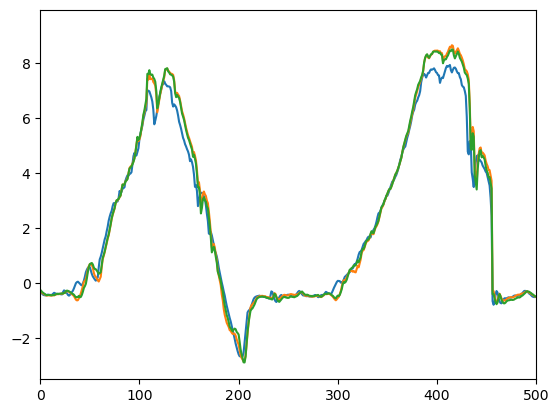

In [22]:
plt.plot(targets_test)
plt.plot(lstm_preds_512)
plt.plot(lstm_preds_128)
plt.xlim(0, 500)

In [23]:
mae_512 = np.square(targets_test - np.stack(lstm_preds_512).flatten()).mean()
mae_128 = np.square(targets_test - np.stack(lstm_preds_128).flatten()).mean()

In [25]:
mae_512

0.2751349403342904